## DVD Inversion exercise (InSAR- High Noise)

This notebook solves DVD inversion exercise using the InSAR datasets

## Import libraries

In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib
import h5py
from vmod import util
from vmod.data import Insar
from vmod.data import Joint
from vmod.source import Mctigue

## Read dataset

In [2]:
xsa,ysa,losa,azsa,incsa=np.loadtxt('examples/dvd/insar/Synth_Asc_High_Correlated.csv',skiprows=1,delimiter=',',unpack=True)
xsd,ysd,losd,azsd,incsd=np.loadtxt('examples/dvd/insar/Synth_Des_High_Correlated.csv',skiprows=1,delimiter=',',unpack=True)
azsa=np.radians(azsa)
azsd=np.radians(azsd)
incsa=np.radians(incsa)
incsd=np.radians(incsd)

In [3]:
nx=401
ny=nx
losaor=np.reshape(losa,(ny,nx))[:,::-1].T
losdor=np.reshape(losd,(ny,nx))[:,::-1].T
azsa=np.reshape(azsa,(ny,nx))[:,::-1].T
azsd=np.reshape(azsd,(ny,nx))[:,::-1].T
incsa=np.reshape(incsa,(ny,nx))[:,::-1].T
incsd=np.reshape(incsd,(ny,nx))[:,::-1].T

In [4]:
extenta=[np.min(xsa),np.max(xsa),np.min(ysa),np.max(ysa)]
extentd=[np.min(xsd),np.max(xsd),np.min(ysd),np.max(ysd)]
#util.mat2quad(losa,azsa,incsa,extenta,name='asc_low.txt',per=15,unit='m')
#util.mat2quad(losd,azsd,incsd,extentd,name='des_low.txt',per=15,unit='m')

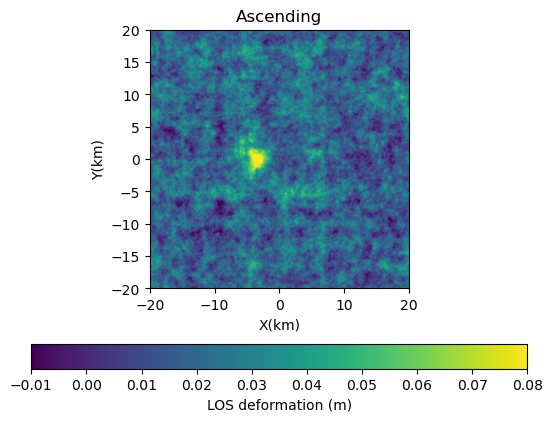

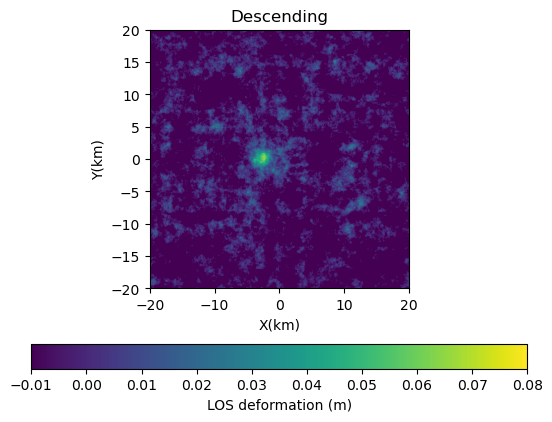

In [5]:
plt.figure()
plt.title('Ascending')
plt.imshow(losaor,extent=np.array(extenta)/1e3,vmin=-0.01,vmax=0.08)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

plt.figure()
plt.title('Descending')
plt.imshow(losdor,extent=np.array(extentd)/1e3,vmin=-0.01,vmax=0.08)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

In [6]:
util.quadtree_var(losaor,azsa,incsa,extent=[-20000,20000,-20000,20000],th=np.nanvar(losa)/50,name='examples/dvd/insar/asc_high.txt')
util.quadtree_var(losdor,azsd,incsd,extent=[-20000,20000,-20000,20000],th=np.nanvar(losd)/50,name='examples/dvd/insar/des_high.txt')

Final samples:  2143
Final samples:  2023


## Reading downsampled data

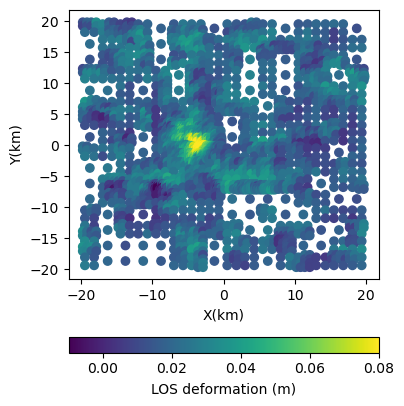

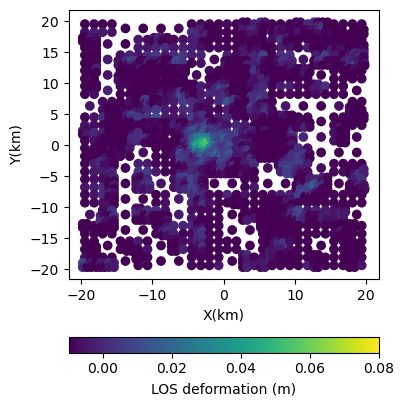

In [7]:
import numpy as np

xsa,ysa,azsa,lksa,losa,elosa,refa=util.read_insar_csv('examples/dvd/insar/asc_high.txt',cref=False)
xsd,ysd,azsd,lksd,losd,elosd,refd=util.read_insar_csv('examples/dvd/insar/des_high.txt',cref=False)

plt.figure(figsize=(4,5))
plt.scatter(xsa/1e3,ysa/1e3,c=losa,vmin=-0.01,vmax=0.08)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

plt.figure(figsize=(4,5))
plt.scatter(xsd/1e3,ysd/1e3,c=losd,vmin=-0.01,vmax=0.08)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

## Create data object

In [8]:
obsa=Insar()
obsa.add_xs(xsa)
obsa.add_ys(ysa)
obsa.add_zs(xsa*0)
obsa.add_vecs(azsa,lksa)
obsa.add_los(losa)
obsa.add_err(elosa)

obsd=Insar()
obsd.add_xs(xsd)
obsd.add_ys(ysd)
obsa.add_zs(xsa*0)
obsd.add_vecs(azsd,lksd)
obsd.add_los(losd)
obsd.add_err(elosd)

obs=Joint()
obs.add_dataset(obsa)
obs.add_dataset(obsd)

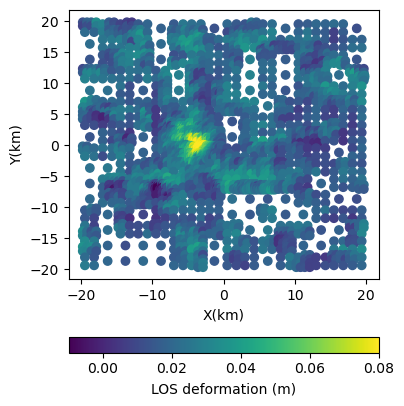

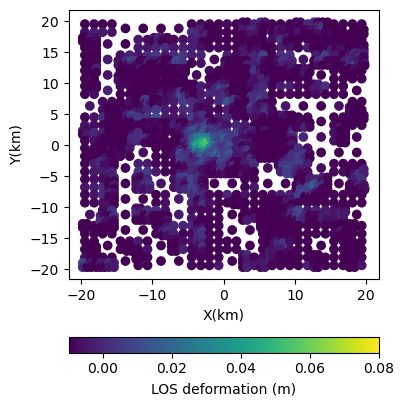

In [9]:
plt.figure(figsize=(4,5))
plt.scatter(xsa/1e3,ysa/1e3,c=obsa.get_data(),vmin=-0.01,vmax=0.08)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(orientation='horizontal',label='LOS deformation (m)')

plt.figure(figsize=(4,5))
plt.scatter(xsd/1e3,ysd/1e3,c=obsd.get_data(),vmin=-0.01,vmax=0.08)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(orientation='horizontal',label='LOS deformation (m)')

## Create model objects for each direction

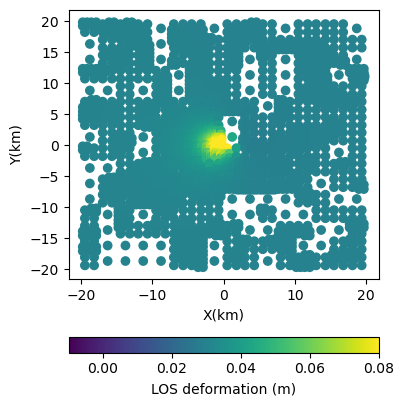

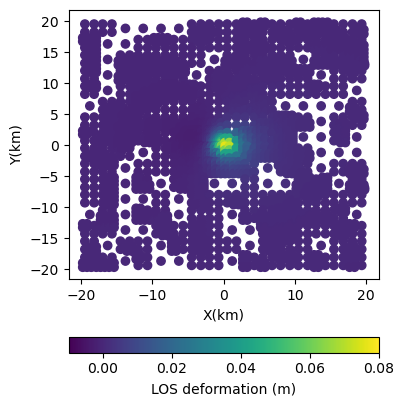

In [10]:
mcta=Mctigue(obsa)
mcta.add_offsets()
losm=mcta.forward([0,0,2.0e3,1.5e3,1e-4,0.03])

plt.figure(figsize=(4,5))
plt.scatter(xsa/1e3,ysa/1e3,c=losm,vmin=-0.01,vmax=0.08)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(orientation='horizontal',label='LOS deformation (m)')

mctd=Mctigue(obsd)
mctd.add_offsets()
losm=mctd.forward([0,0,2.0e3,1.5e3,1e-4,0])

plt.figure(figsize=(4,5))
plt.scatter(xsd/1e3,ysd/1e3,c=losm,vmin=-0.01,vmax=0.08)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(orientation='horizontal',label='LOS deformation (m)')

## Create object model for joint data

In [11]:
mct=Mctigue(obs)
mct.add_offsets()
#Bounds for parameters
mct.set_bounds(low_bounds = [-20000,-20000,1e2,1e2,-1e-2,0,-0.1], high_bounds = [20000,20000,9e4,5e3,1e-2,0.1,0])

## Create Inversion object

In [12]:
from vmod.inverse import Inverse

inv=Inverse(obs)
inv.register_source(mct)

## Least-squares inversion

In [14]:
params=inv.nlsq()

100%|██████████| 64/64 [05:18<00:00,  4.97s/it]


In [15]:
parnames,orders=inv.get_parnames_orders()
for i,parname in enumerate(parnames):
    print(parname,params[i])

xcen -3086.2958670112625
ycen 193.0147316458299
depth 2213.505230310488
radius 2213.4925165943137
dP 2.5407620259972028e-05
offset0 0.018734438246484676
offset1 -0.010644995603188906


## Forward model with least squares solution

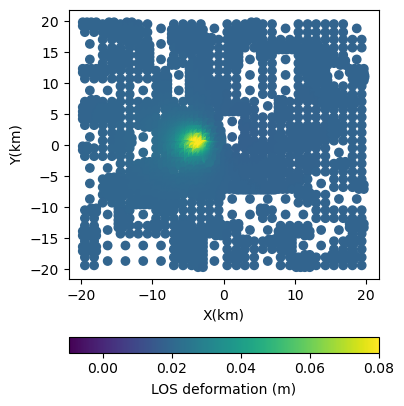

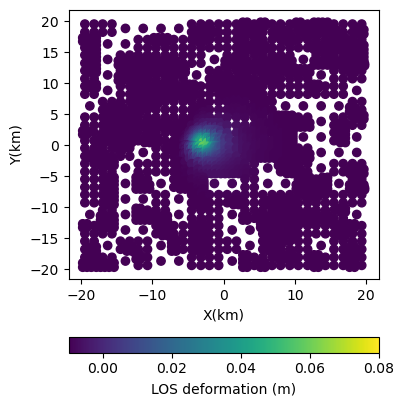

In [19]:
ansa=params[0:len(params)-1]
ansd=np.concatenate((params[0:len(params)-2],[params[-1]]))

losm=mcta.forward(ansa)

plt.figure(figsize=(4,5))
plt.scatter(xsa/1e3,ysa/1e3,c=losm,vmin=-0.01,vmax=0.08)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(orientation='horizontal',label='LOS deformation (m)')

losm=mctd.forward(ansd)

plt.figure(figsize=(4,5))
plt.scatter(xsd/1e3,ysd/1e3,c=losm,vmin=-0.01,vmax=0.08)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(orientation='horizontal',label='LOS deformation (m)')

## Bayesian inversion

In [ ]:
trace=inv.mcmc_em('insar_high_off_dP')

In [32]:
import pickle

with open('insar_high_off_dP.pkl','rb') as handle:
    dic=pickle.load(handle)

trace=[dic[key] for key in dic.keys()]

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2492/2451783867.py:16: SyntaxWarning: invalid escape sequence '\m'
  labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$','D(km)','R(km)','$P(\mu)$','Off A(cm)','Off D(cm)']


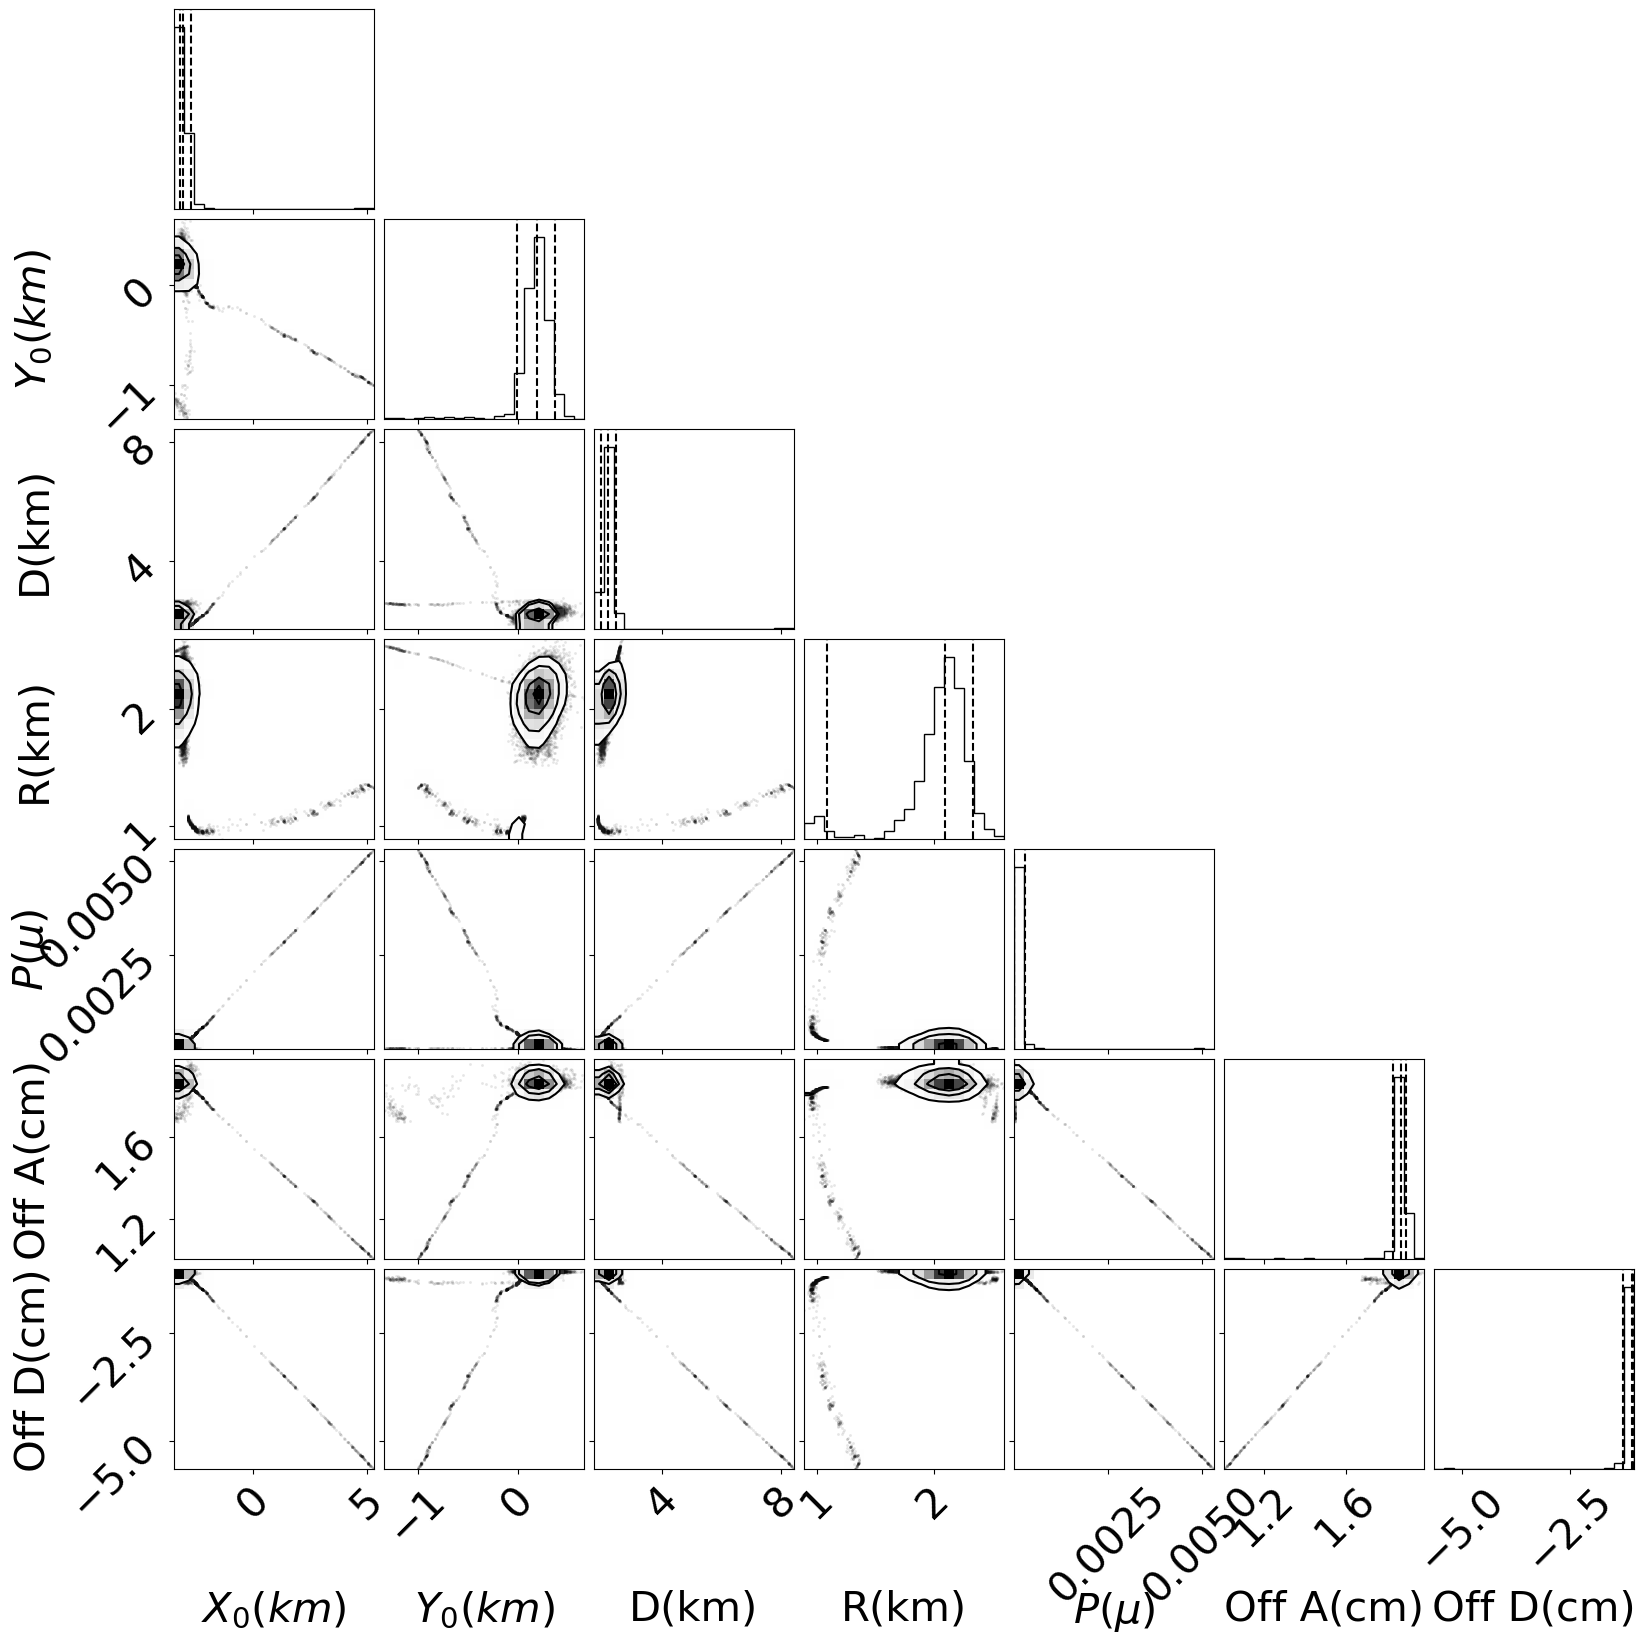

In [33]:
%matplotlib inline
data=[]
labels=[]
parnames,orders=inv.get_parnames_orders()
for i,tr in enumerate(trace):
    data.append(tr[:])
    labels.append(parnames[i])
data=np.vstack(data)
newdata=np.copy(data)
newdata[0,:]=newdata[0,:]/1e3
newdata[1,:]=newdata[1,:]/1e3
newdata[2,:]=newdata[2,:]/1e3
newdata[3,:]=newdata[3,:]/1e3
newdata[5,:]=newdata[5,:]*1e2
newdata[6,:]=newdata[6,:]*1e2
labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$','D(km)','R(km)','$P(\mu)$','Off A(cm)','Off D(cm)']

plt.rcParams.update({'font.size': 30})
figure = corner.corner(newdata.T, labels=labels,
                       quantiles=[0.05, 0.5, 0.95],smooth=0.7,max_n_ticks=2,labelpad=0.3,
                       show_titles=False, label_kwargs={"fontsize": 30}, title_kwargs={"fontsize": 30})
plt.savefig('histograms')

## Calculation of percentiles to upload the results

In [34]:
means=[np.percentile(data[i,:],50) for i in range(data.shape[0])]
lower95=[np.percentile(data[i,:],5)-np.percentile(data[i,:],50) for i in range(data.shape[0])]
upper95=[np.percentile(data[i,:],95)-np.percentile(data[i,:],50) for i in range(data.shape[0])]
lower32=[np.percentile(data[i,:],32) for i in range(data.shape[0])]
upper68=[np.percentile(data[i,:],68) for i in range(data.shape[0])]

results=[means,lower95,upper95,lower32,upper68]

for res in results:
    for i in range(len(res)):
        if i in [0,1,2,3]:
            res[i]=res[i]
        elif i in [4,5]:
            res[i]=res[i]
        elif i in [6]:
            res[i]=res[i]
    print("%.2f,%.2f,%.2f,%.2f,%.2f,%.2f,%.2f"%(tuple(res)))

-3070.67,190.85,2165.93,2092.11,0.00,0.02,-0.01
-144.62,-202.41,-236.75,-1008.27,-0.00,-0.00,-0.00
371.59,176.49,250.87,243.16,0.00,0.00,0.00
-3115.10,141.74,2102.65,2005.17,0.00,0.02,-0.01
-3024.92,240.37,2229.98,2166.44,0.00,0.02,-0.01


[-3.07067190e+03  1.90852836e+02  2.16593144e+03  2.09210957e+03
  3.02334880e-05  1.87279699e-02] [-3.07067190e+03  1.90852836e+02  2.16593144e+03  2.09210957e+03
  3.02334880e-05 -1.06630121e-02]


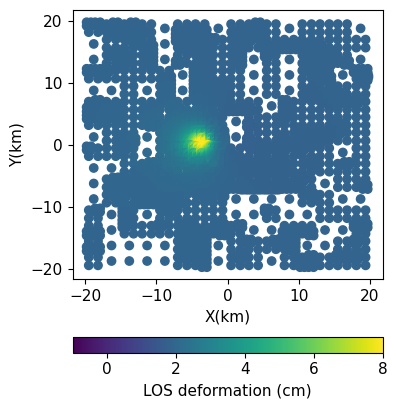

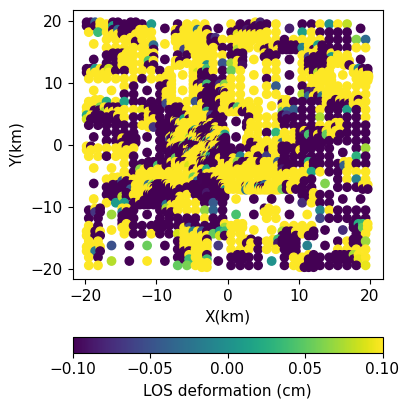

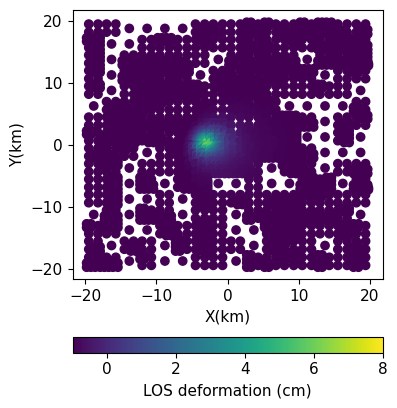

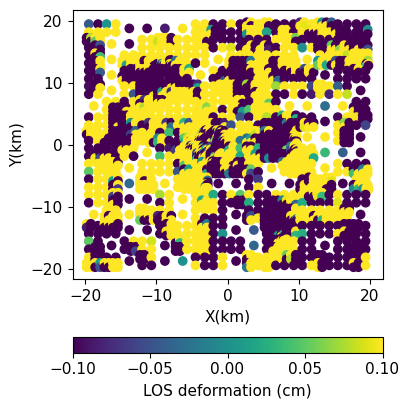

In [40]:
plt.rcParams.update({'font.size': 11})
ansa=np.concatenate((means[0:5],[means[5]]))
ansd=np.concatenate((means[0:5],[means[6]]))

print(ansa,ansd)

losma=mcta.forward(ansa)

plt.figure(figsize=(4,5))
plt.scatter(xsa/1e3,ysa/1e3,c=losma*1e2,vmin=-1,vmax=8)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)')

plt.figure(figsize=(4,5))
plt.scatter(xsa/1e3,ysa/1e3,c=(obsa.get_data()-losma)*1e2,vmin=-0.1,vmax=0.1)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)')

losmd=mctd.forward(ansd)

plt.figure(figsize=(4,5))
plt.scatter(xsd/1e3,ysd/1e3,c=losmd*1e2,vmin=-1,vmax=8)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)')

plt.figure(figsize=(4,5))
plt.scatter(xsd/1e3,ysd/1e3,c=(obsd.get_data()-losmd)*1e2,vmin=-0.1,vmax=0.1)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)')

Text(0, 0.5, 'Y(km)')

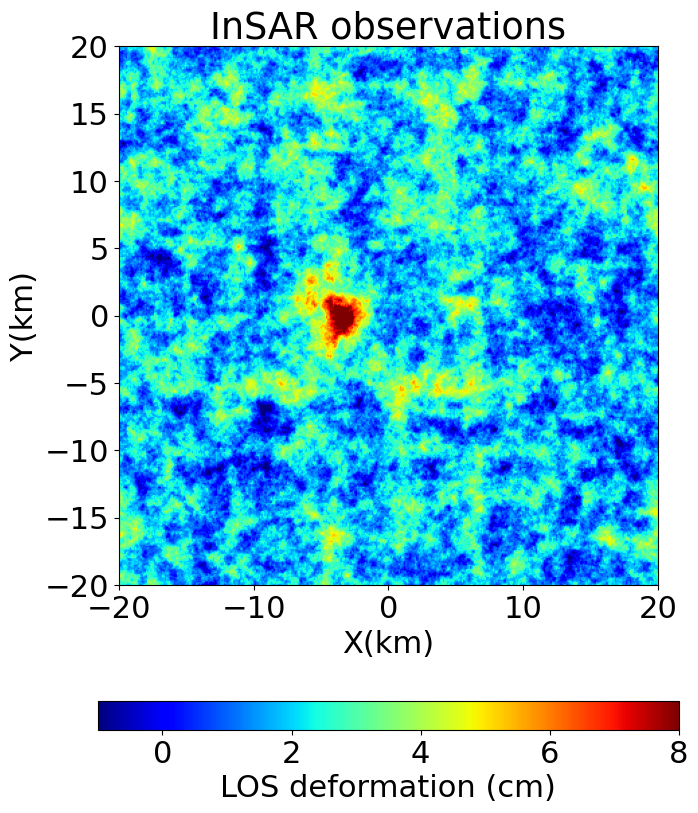

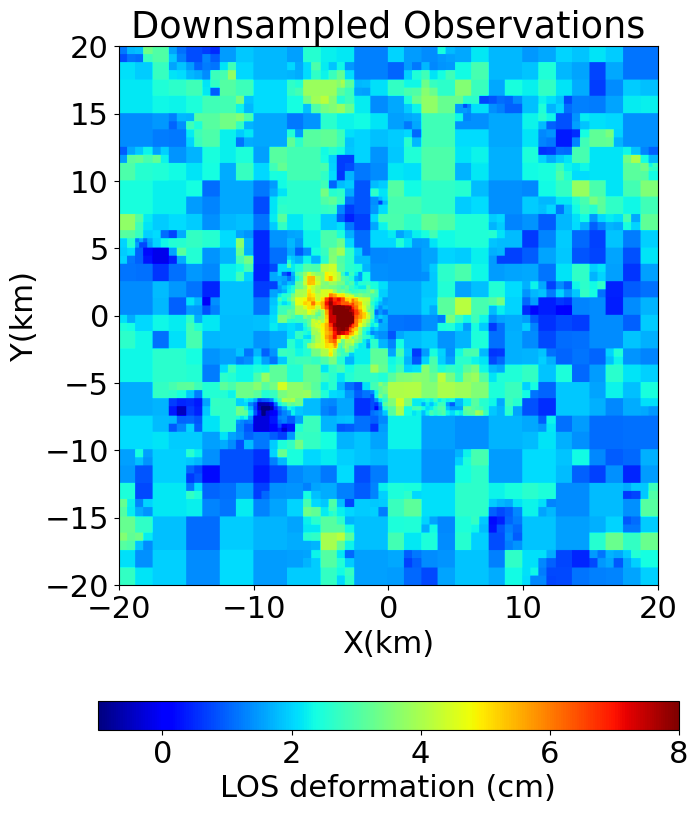

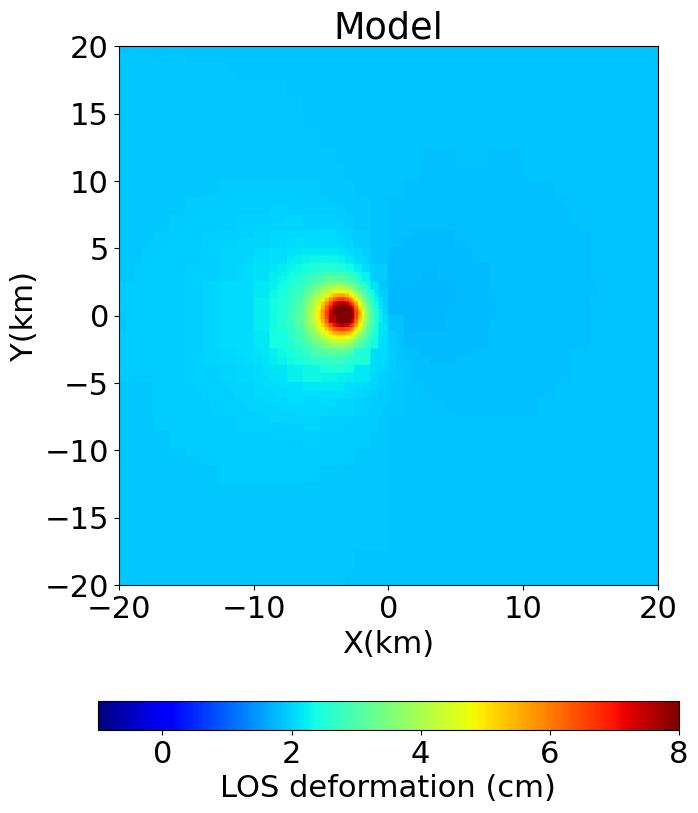

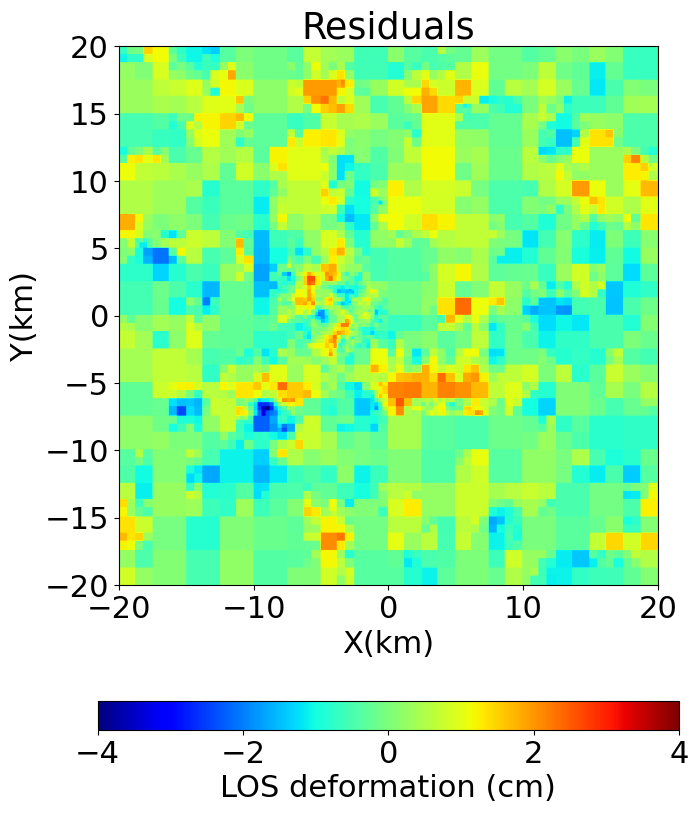

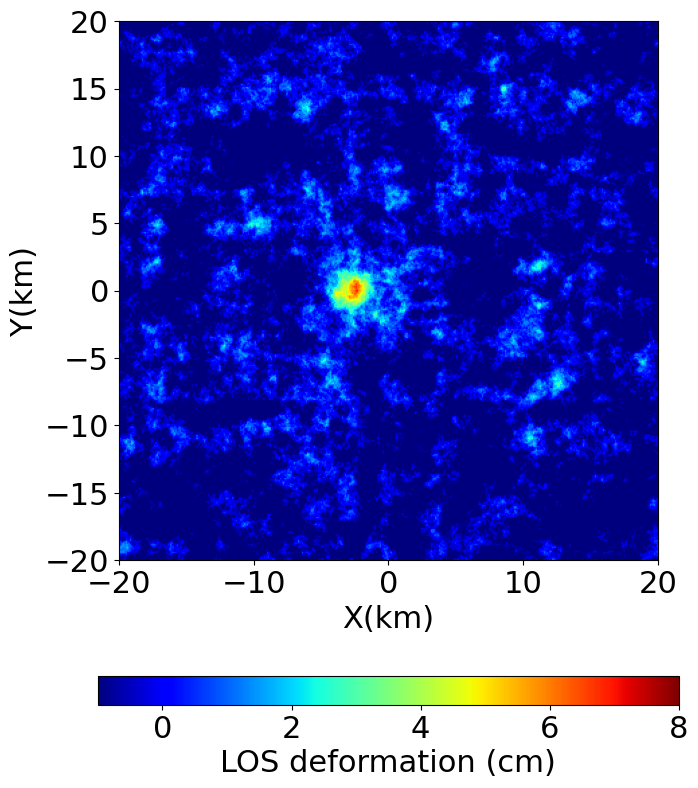

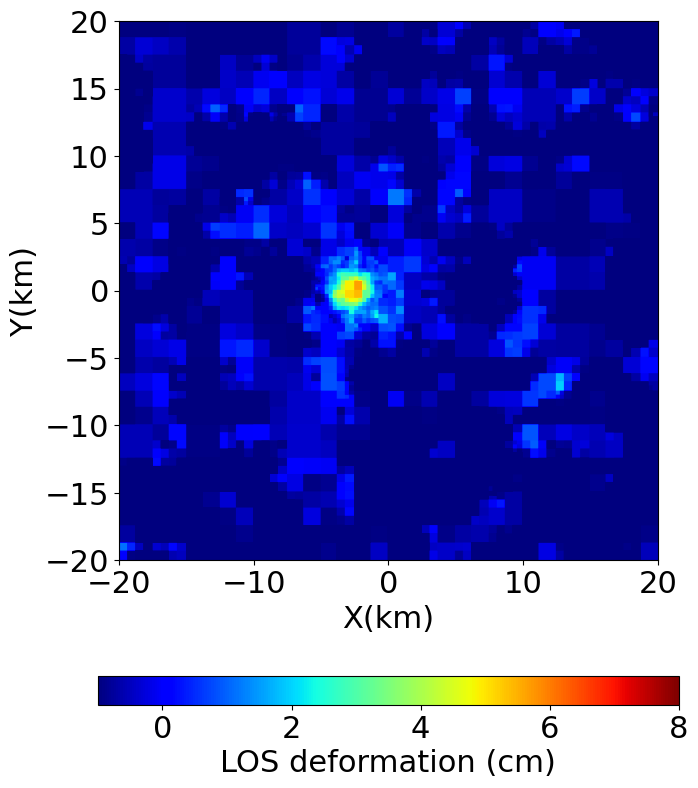

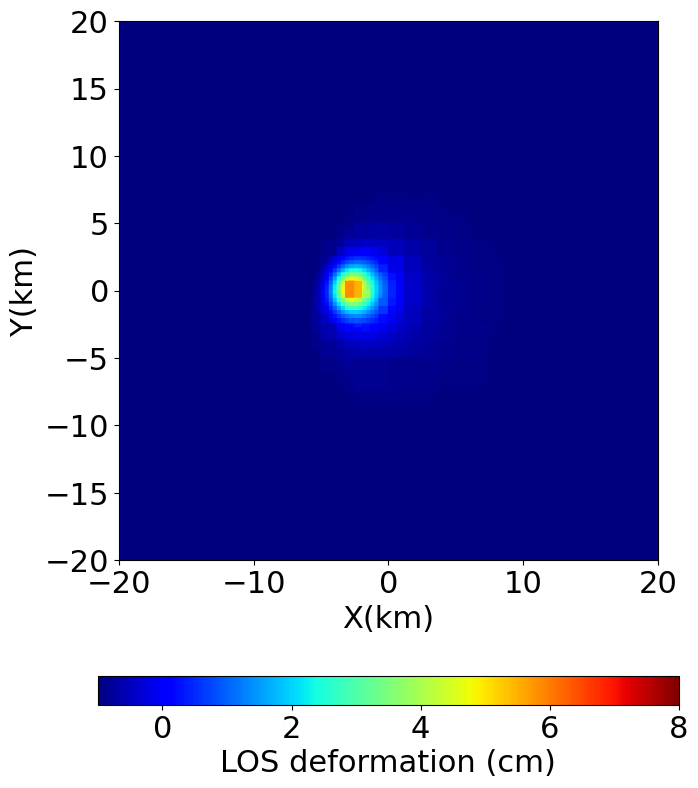

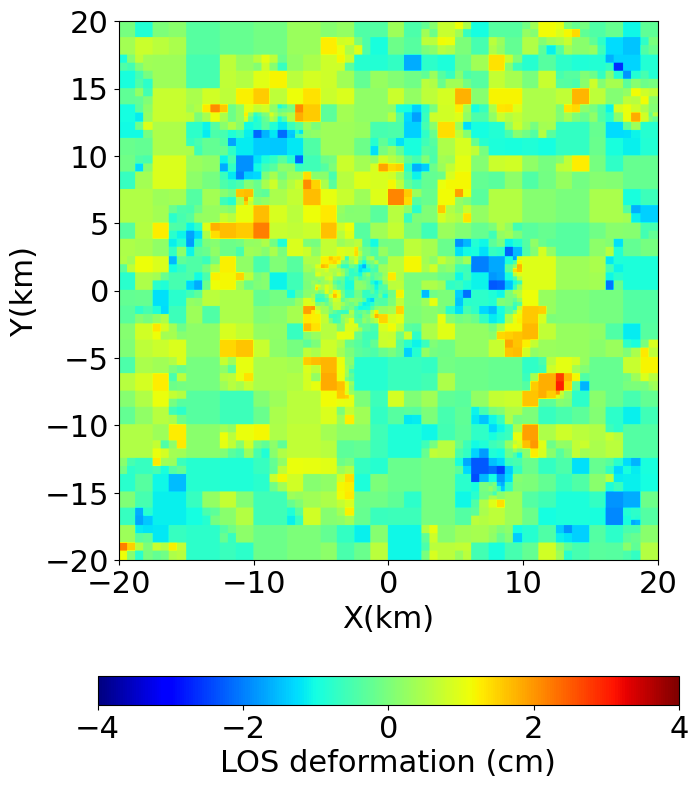

In [41]:
plt.rcParams.update({'font.size': 22})

qmapa,extent=util.los2npy(obsa.get_data(),'examples/dvd/insar/asc_high.txt',cref=False)

plt.figure(figsize=(10,10))
plt.title('InSAR observations')
plt.imshow(losaor*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
#plt.text(5,15,s='Ascending')
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

plt.figure(figsize=(10,10))
plt.title('Downsampled Observations')
plt.imshow(qmapa*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

qmapma,extent=util.los2npy(losma,'examples/dvd/insar/asc_high.txt',cref=False)

plt.figure(figsize=(10,10))
plt.title('Model')
plt.imshow(qmapma*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

plt.figure(figsize=(10,10))
plt.title('Residuals')
plt.imshow((qmapa-qmapma)*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-4,vmax=4,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

qmapd,extent=util.los2npy(obsd.get_data(),'examples/dvd/insar/des_high.txt',cref=False)

plt.figure(figsize=(10,10))
#plt.title('Observations')
plt.imshow(losdor*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
#plt.text(5,15,s='Descending',c='white')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

plt.figure(figsize=(10,10))
#plt.title('Downsampled observations')
plt.imshow(qmapd*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

qmapmd,extent=util.los2npy(losmd,'examples/dvd/insar/des_high.txt',cref=False)

plt.figure(figsize=(10,10))
#plt.title('Model')
plt.imshow(qmapmd*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

plt.figure(figsize=(10,10))
#plt.title('Residuals')
plt.imshow((qmapd-qmapmd)*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-4,vmax=4,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')